In [1]:
!python graph_based_sampling.py

1 [{}, {'V': ['sample0'], 'A': {}, 'P': {'sample0': ['sample*', ['normal', 5, ['sqrt', 2]]]}, 'Y': {}}, 'sample0']
p value 0.39835282995548604
2 [{}, {'V': ['sample0'], 'A': {}, 'P': {'sample0': ['sample*', ['beta', 2, 5]]}, 'Y': {}}, 'sample0']
p value 0.11583209715017795
3 [{}, {'V': ['sample0'], 'A': {}, 'P': {'sample0': ['sample*', ['exponential', 0.2]]}, 'Y': {}}, 'sample0']
p value 0.9646291365609472
4 [{}, {'V': ['sample0'], 'A': {}, 'P': {'sample0': ['sample*', ['normal', 5.3, 3.2]]}, 'Y': {}}, 'sample0']
p value 0.47286803559706114
5 [{}, {'V': ['sample0', 'sample1'], 'A': {'uniform': ['sample0'], 'sample0': ['sample1']}, 'P': {'sample0': ['sample*', ['uniform', 0, 1]], 'sample1': ['sample*', ['normal', ['if', ['<', 'sample0', 0.1], -1, 1], ['sqrt', 0.09]]]}, 'Y': {}}, 'sample1']
p value 0.09236896738377387
6 [{'get-sig': ['fn', ['var'], ['*', 'var', 'var']]}, {'V': ['sample0'], 'A': {}, 'P': {'sample0': ['sample*', ['normal', 0, 1.44]]}, 'Y': {}}, 'sample0']
p value 0.1380135

In [1]:
import torch
import torch.distributions as dist

from daphne import daphne
from primitives import *
from tests import is_tol, run_prob_test,load_truth

#from primitives import standard_env

# Put all function mappings from the deterministic language environment to your
# Python evaluation context here:
#env = {'normal': dist.Normal,'sqrt': torch.sqrt,'vector': }

env = standard_env()

env.update({
	#'vector' : lambda *x: torch.tensor(x),
	'vector' : lambda *x: eval(['vector', x]),
	'hash-map': lambda *x: eval(['hash-map', x]),
	})
#print (global_env)

def deterministic_eval(exp):
	"Evaluation function for the deterministic target language of the graph based representation."
	#print ('in', exp)
	#print (env)
	if type(exp) is list:
		op = exp[0]
		args = exp[1:]
		return env[op](*map(deterministic_eval, args))
		#for i in exp:
		#    val = eval(i)
		#return val
	elif type(exp) is int or type(exp) is float:
		# We use torch for all numerical objects in our evaluator
		return torch.tensor(float(exp))
	else:
		raise("Expression type unknown.", exp)


def sample_from_joint(graph):
	"This function does ancestral sampling starting from the prior."
	# TODO insert your code here

	#print (graph[1]['P'])
	search_graph = graph[1]['P']

	#print ('to return', graph[-1])

	ret = {}

	#print (search_graph)

	search = list(search_graph.keys())

	'''
	for i, key in enumerate(search):
		if len(key)<8:
			search[i] = 'sample0'+key[6]
			print (search[i], key)
			search_graph[search[i]] = search_graph.pop(key)
		print (search_graph[key])
		if len(search_graph[key][-1])<8:
            print ('less', search_graph[key])

	search.sort()
	'''

	#print ('here', search)

	search = sorted_alnum(search)

	#print (search)

	for node in search:

		if search_graph[node][0] != 'observe*':
			if search_graph[node][0] == 'sample*':
				search_graph[node][0] = 'sample'
			#print ('topo', node, search_graph[node])
			val = eval(search_graph[node], env)
			#print (val)
			ret[node] = val.item()
			#env.update({    node:val,})
			env[node] = val
			#print ('here', env.find(node))
			#print(node, env[node])
			#print (val)

	if isinstance(graph[-1], list):
		return eval(graph[-1], env)

	return [ret[graph[-1]]]


def get_stream(graph):
	"""Return a stream of prior samples
	Args: 
		graph: json graph as loaded by daphne wrapper
	Returns: a python iterator with an infinite stream of samples
		"""
	while True:
		yield sample_from_joint(graph)


#Testing:

def run_deterministic_tests():

	print ('running det')
	
	for i in range(1,13):
		#note: this path should be with respect to the daphne path!
		graph = daphne(['graph','-i','/Users/gaurav/Desktop/CS532-HW2/programs/tests/deterministic/test_{}.daphne'.format(i)])
		truth = load_truth('programs/tests/deterministic/test_{}.truth'.format(i))

		print (i, ' ',graph)

		ret = deterministic_eval(graph[-1])
		try:
			assert(is_tol(ret, truth))
		except AssertionError:
			raise AssertionError('return value {} is not equal to truth {} for graph {}'.format(ret,truth,graph))
		
		print('Test passed')
		
	print('All deterministic tests passed')
	


def run_probabilistic_tests():
	
	#TODO: 
	num_samples=1e5
	max_p_value = 1e-4
	
	for i in range(1,7):
		#note: this path should be with respect to the daphne path!        
		graph = daphne(['graph', '-i', '/Users/gaurav/Desktop/CS532-HW2/programs/tests/probabilistic/test_{}.daphne'.format(i)])
		truth = load_truth('programs/tests/probabilistic/test_{}.truth'.format(i))

		print (i, graph)
		
		stream = get_stream(graph)
		
		p_val = run_prob_test(stream, truth, num_samples)
		
		print('p value', p_val)
		assert(p_val > max_p_value)
	
	print('All probabilistic tests passed')

In [2]:
graphs = {}
for i in range(1,5):
    graphs[i] = daphne(['graph','-i','/Users/gaurav/Desktop/CS532-HW2/programs/{}.daphne'.format(i)])
    #print('\n\n\nSample of prior of program {}:'.format(i))
    #print (graph)
    #hmap[i].append(sample_from_joint(graph))

In [3]:
hmap = {}
for j in range(4):
    hmap[j+1] = []
samples = 500
for k in range(samples):
    #print ('done .... ')
    for i in range(1,5):
        #graph = daphne(['graph','-i','/Users/gaurav/Desktop/CS532-HW2/programs/{}.daphne'.format(i)])
        #print('\n\n\nSample of prior of program {}:'.format(i))
        #print (graph)
        hmap[i].append(sample_from_joint(graphs[i]))

In [121]:
#hmap

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
out1 = torch.tensor(hmap[1])
out2 = torch.stack(hmap[2])
out3 = torch.stack(hmap[3])

out40 = torch.stack([i[0] for i in hmap[4]]).squeeze()
out41 = torch.stack([i[1] for i in hmap[4]]).squeeze()
out42 = torch.stack([i[2] for i in hmap[4]]).squeeze()
out43 = torch.stack([i[3] for i in hmap[4]]).squeeze()

In [68]:
o = [i[0] for i in hmap[4]]

In [81]:
out42.shape

torch.Size([2, 10, 10])

(array([6.71381362, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 6.71380825]),
 array([0.4132477 , 0.48772103, 0.56219435, 0.6366677 , 0.71114105,
        0.7856144 , 0.8600877 , 0.934561  , 1.0090344 , 1.0835077 ,
        1.157981  ], dtype=float32),
 <BarContainer object of 10 artists>)

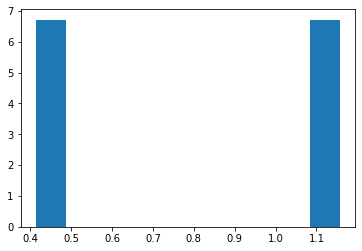

In [85]:
plt.hist(np.array(out1), density=True)

(array([0.00108721, 0.00574667, 0.01320181, 0.02982055, 0.03680974,
        0.037431  , 0.020191  , 0.00885298, 0.00170847, 0.00046595]),
 array([-30.19906  , -23.760548 , -17.322033 , -10.88352  ,  -4.445007 ,
          1.9935064,   8.43202  ,  14.870533 ,  21.309046 ,  27.74756  ,
         34.186073 ], dtype=float32),
 <BarContainer object of 10 artists>)

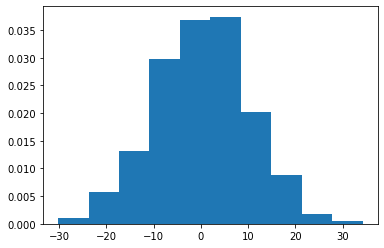

In [35]:
plt.hist(np.array(out2[:,0]), density=True)

(array([0.00093214, 0.00108749, 0.0071464 , 0.01895348, 0.03153735,
        0.04023731, 0.03122664, 0.01662314, 0.00528212, 0.00233035]),
 array([-34.923824 , -28.487013 , -22.0502   , -15.613388 ,  -9.176577 ,
         -2.7397642,   3.6970477,  10.13386  ,  16.570671 ,  23.007484 ,
         29.444296 ], dtype=float32),
 <BarContainer object of 10 artists>)

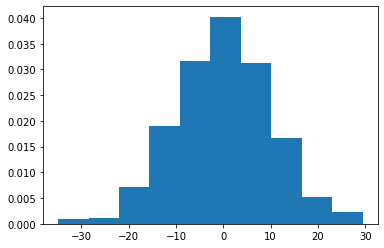

In [36]:
plt.hist(np.array(out2[:,1]), density=True)

(array([ 67.,   0.,   0.,   0.,   0., 102.,   0.,   0.,   0., 331.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

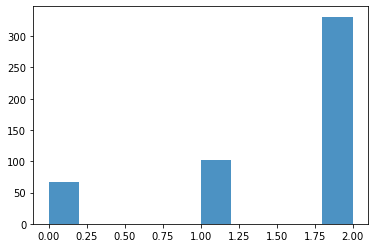

In [33]:
plt.hist(np.array(out3[:,8]), alpha=0.8)

In [31]:
out3[:,8].shape

torch.Size([500])

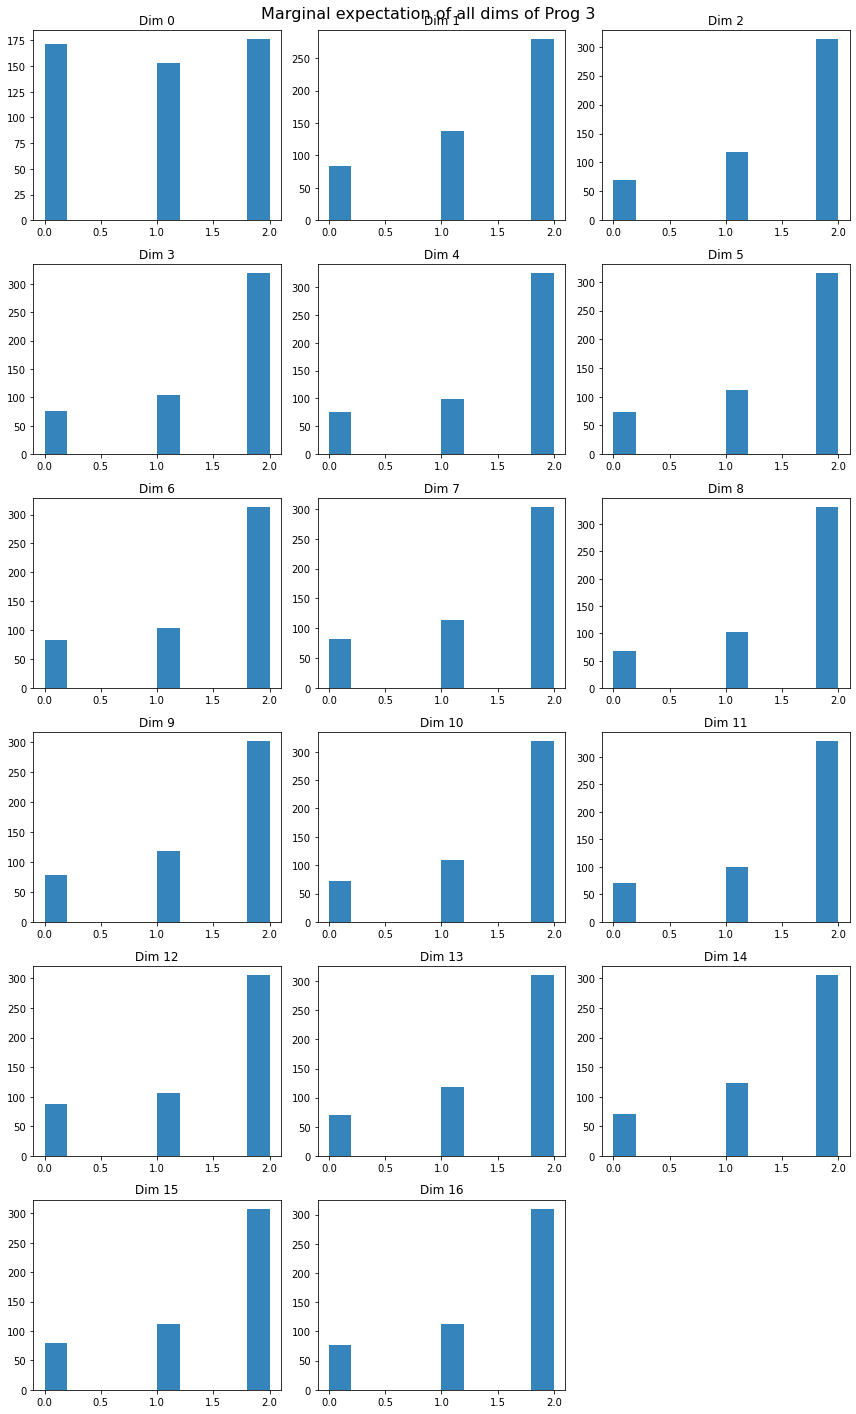

In [47]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

with PdfPages('foo.pdf') as pdf:
    #As many times as you like, create a figure fig and save it:
    #fig = plt.figure()
    fig = plt.figure(figsize=(12, 20))
    
    fig.suptitle('Marginal expectation of all dims of Prog 3', fontsize=16)

    G = GridSpec(int(out3.shape[1]/3)+1,3) 
    count = 0
    
    for i in range(0, out3.shape[1], 3):
        
        axes_1 = fig.add_subplot(G[count, 0])
        axes_1.set_title('Dim '+str(i))
        axes_1.hist(np.array(out3[:,i]), alpha=0.9, label='x')
        
        if i+1<out3.shape[1]:
            axes_2 = fig.add_subplot(G[count, 1])
            axes_2.set_title('Dim '+str(i+1))
            axes_2.hist(np.array(out3[:,i+1]), alpha=0.9, label='x')
        if i+2<out3.shape[1]:
            axes_3 = fig.add_subplot(G[count, 2])
            axes_3.set_title('Dim '+str(i+2))
            axes_3.hist(np.array(out3[:,i+2]), alpha=0.9, label='x')
            count += 1

    plt.tight_layout()
    #plt.show()
    
    pdf.savefig(fig)

    #....
    #fig = plt.figure()
    #pdf.savefig(fig)

In [54]:
out42.shape

torch.Size([500, 10, 10])

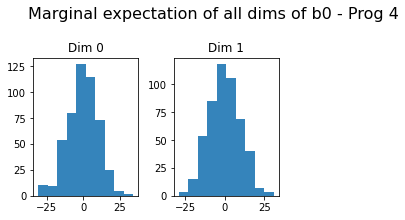

In [110]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

#out = out42.view(samples,-1)
out = out2
space = 3

with PdfPages('foo.pdf') as pdf:
    #As many times as you like, create a figure fig and save it:
    #fig = plt.figure()
    
    #fig = plt.figure(figsize=(13, 18))
    
    fig = plt.figure(figsize=(6, 3))
    
    #fig = plt.figure(figsize=(10, 5))

    fig.suptitle('Marginal expectation of all dims of b0 - Prog 4', fontsize=16, y=1)

    G = GridSpec(int(out.shape[1]/space)+1,space) 
    count = 0
    
    for i in range(0, int(out.shape[1]/space)+1):
        
        for j in range(space):
            
            if (i*space+j)<out.shape[1]:
                axes_1 = fig.add_subplot(G[i, j])
                axes_1.set_title('Dim '+str(i*space+j))
                axes_1.hist(np.array(out[:,i*space+j]), alpha=0.9, label='x')

            '''
            if i+1<out.shape[1]:
                axes_2 = fig.add_subplot(G[count, 1])
                axes_2.set_title('Dim '+str(i+1))
                axes_2.hist(np.array(out[:,i+1]), alpha=0.9, label='x')
            if i+2<out.shape[1]:
                axes_3 = fig.add_subplot(G[count, 2])
                axes_3.set_title('Dim '+str(i+2))
                axes_3.hist(np.array(out[:,i+2]), alpha=0.9, label='x')
            '''

    plt.tight_layout(pad=1)
    #plt.show()
    
    pdf.savefig(fig)

In [113]:
from scipy import stats

In [123]:
a = stats.describe(out2[:,0])

In [122]:
stats.describe(out2[:,1])

DescribeResult(nobs=500, minmax=(-29.2398, 30.88854), mean=-0.2793532, variance=95.51165, skewness=0.056363513150550666, kurtosis=-0.2081408485536116)

In [118]:
hmap[2]

[tensor([2.0995, 2.8518]),
 tensor([-3.0653,  3.7327]),
 tensor([-3.4947, -1.0234]),
 tensor([-12.0125,  -4.5972]),
 tensor([ 4.8422, 10.7574]),
 tensor([-4.6313,  8.3101]),
 tensor([-8.4976, 13.3599]),
 tensor([ 9.8970, -7.3148]),
 tensor([13.1292, -0.4360]),
 tensor([-10.0579,  13.1068]),
 tensor([  4.9005, -17.1923]),
 tensor([-26.1558, -11.7534]),
 tensor([9.1913, 5.9709]),
 tensor([-5.9399,  5.1413]),
 tensor([-5.8649, -8.7910]),
 tensor([ 8.8653, -8.3232]),
 tensor([ 1.4984, 12.9779]),
 tensor([ 9.3639, -2.4801]),
 tensor([-16.3731,   3.7244]),
 tensor([ 15.3403, -15.2802]),
 tensor([-12.9378,   5.0683]),
 tensor([7.5298, 1.6635]),
 tensor([-1.8001, -6.2886]),
 tensor([-18.9574,   4.5355]),
 tensor([-3.1669, -2.1191]),
 tensor([ 1.9709, -0.1382]),
 tensor([ -9.8811, -10.9381]),
 tensor([ 2.6593, -8.0712]),
 tensor([-0.9092,  6.2495]),
 tensor([-1.9548, -9.4278]),
 tensor([6.6050, 4.5369]),
 tensor([11.5601,  0.0136]),
 tensor([-3.3405, 16.8052]),
 tensor([-10.5877,  17.1196]),
 t